<a href="https://colab.research.google.com/github/Jingut/EX/blob/main/Exp_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
튜닝해볼 수 있는 모델 클래스 인자
대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같습니다.

max_depth : 의사 결정 나무의 깊이, 정수 사용
learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력
위에서 저는 n_estimators와 max_depth 에 대해서만 아주 간단하게 실험했지만, 훨씬 더 다양하게 실험을 하며 최적의 조합을 찾아볼 수 있습니다.
실제로 lightgbm에 넣을 수 있는 인자는 아래 자료들에서 설명하는 것처럼 매우 다양합니다.
'''

'\n튜닝해볼 수 있는 모델 클래스 인자\n대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같습니다.\n\nmax_depth : 의사 결정 나무의 깊이, 정수 사용\nlearning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용\nn_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용\nnum_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수\nboosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력\n위에서 저는 n_estimators와 max_depth 에 대해서만 아주 간단하게 실험했지만, 훨씬 더 다양하게 실험을 하며 최적의 조합을 찾아볼 수 있습니다.\n실제로 lightgbm에 넣을 수 있는 인자는 아래 자료들에서 설명하는 것처럼 매우 다양합니다.\n'

# 필요한 라이브러리 호출

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats

# 데이터 디렉토리 경로 지정

In [3]:
data_dir = '/content/drive/MyDrive/kaggle-kakr-housing-data/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/content/drive/MyDrive/kaggle-kakr-housing-data/data/train.csv
/content/drive/MyDrive/kaggle-kakr-housing-data/data/test.csv


# 판다스 라이브러리를 이용하여 각 csv파일을 불러오기

In [4]:
data = pd.read_csv('/content/drive/MyDrive/kaggle-kakr-housing-data/data/train.csv')
sub = pd.read_csv('/content/drive/MyDrive/kaggle-kakr-housing-data/data/test.csv')
print('train data dim : {}'.format(data.shape))# 훈련데이터 확인
print('sub data dim : {}'.format(sub.shape))# 테스트 데이터확인

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [5]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


# price 컬럼은 라벨로 쓰기 위해 따로 y값으로 저장해둔 후 학습데이터에서는 삭제한다.

In [6]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


# 학습데이터와 테스트 데이터 합치기

학습 전에 전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat으로 합쳐본다.
모델 학습을 진행할 때에는 다시 분리해서 사용해야 하기 때문에 데이터를 합치기 전 train_len에 training data의 개수를 저장한다.

In [7]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))
len(sub)

21503


6468

# 데이터 전처리하기


# 결측치 확인

missingno라이브러리를 사용하여 결측치를 확인한다.

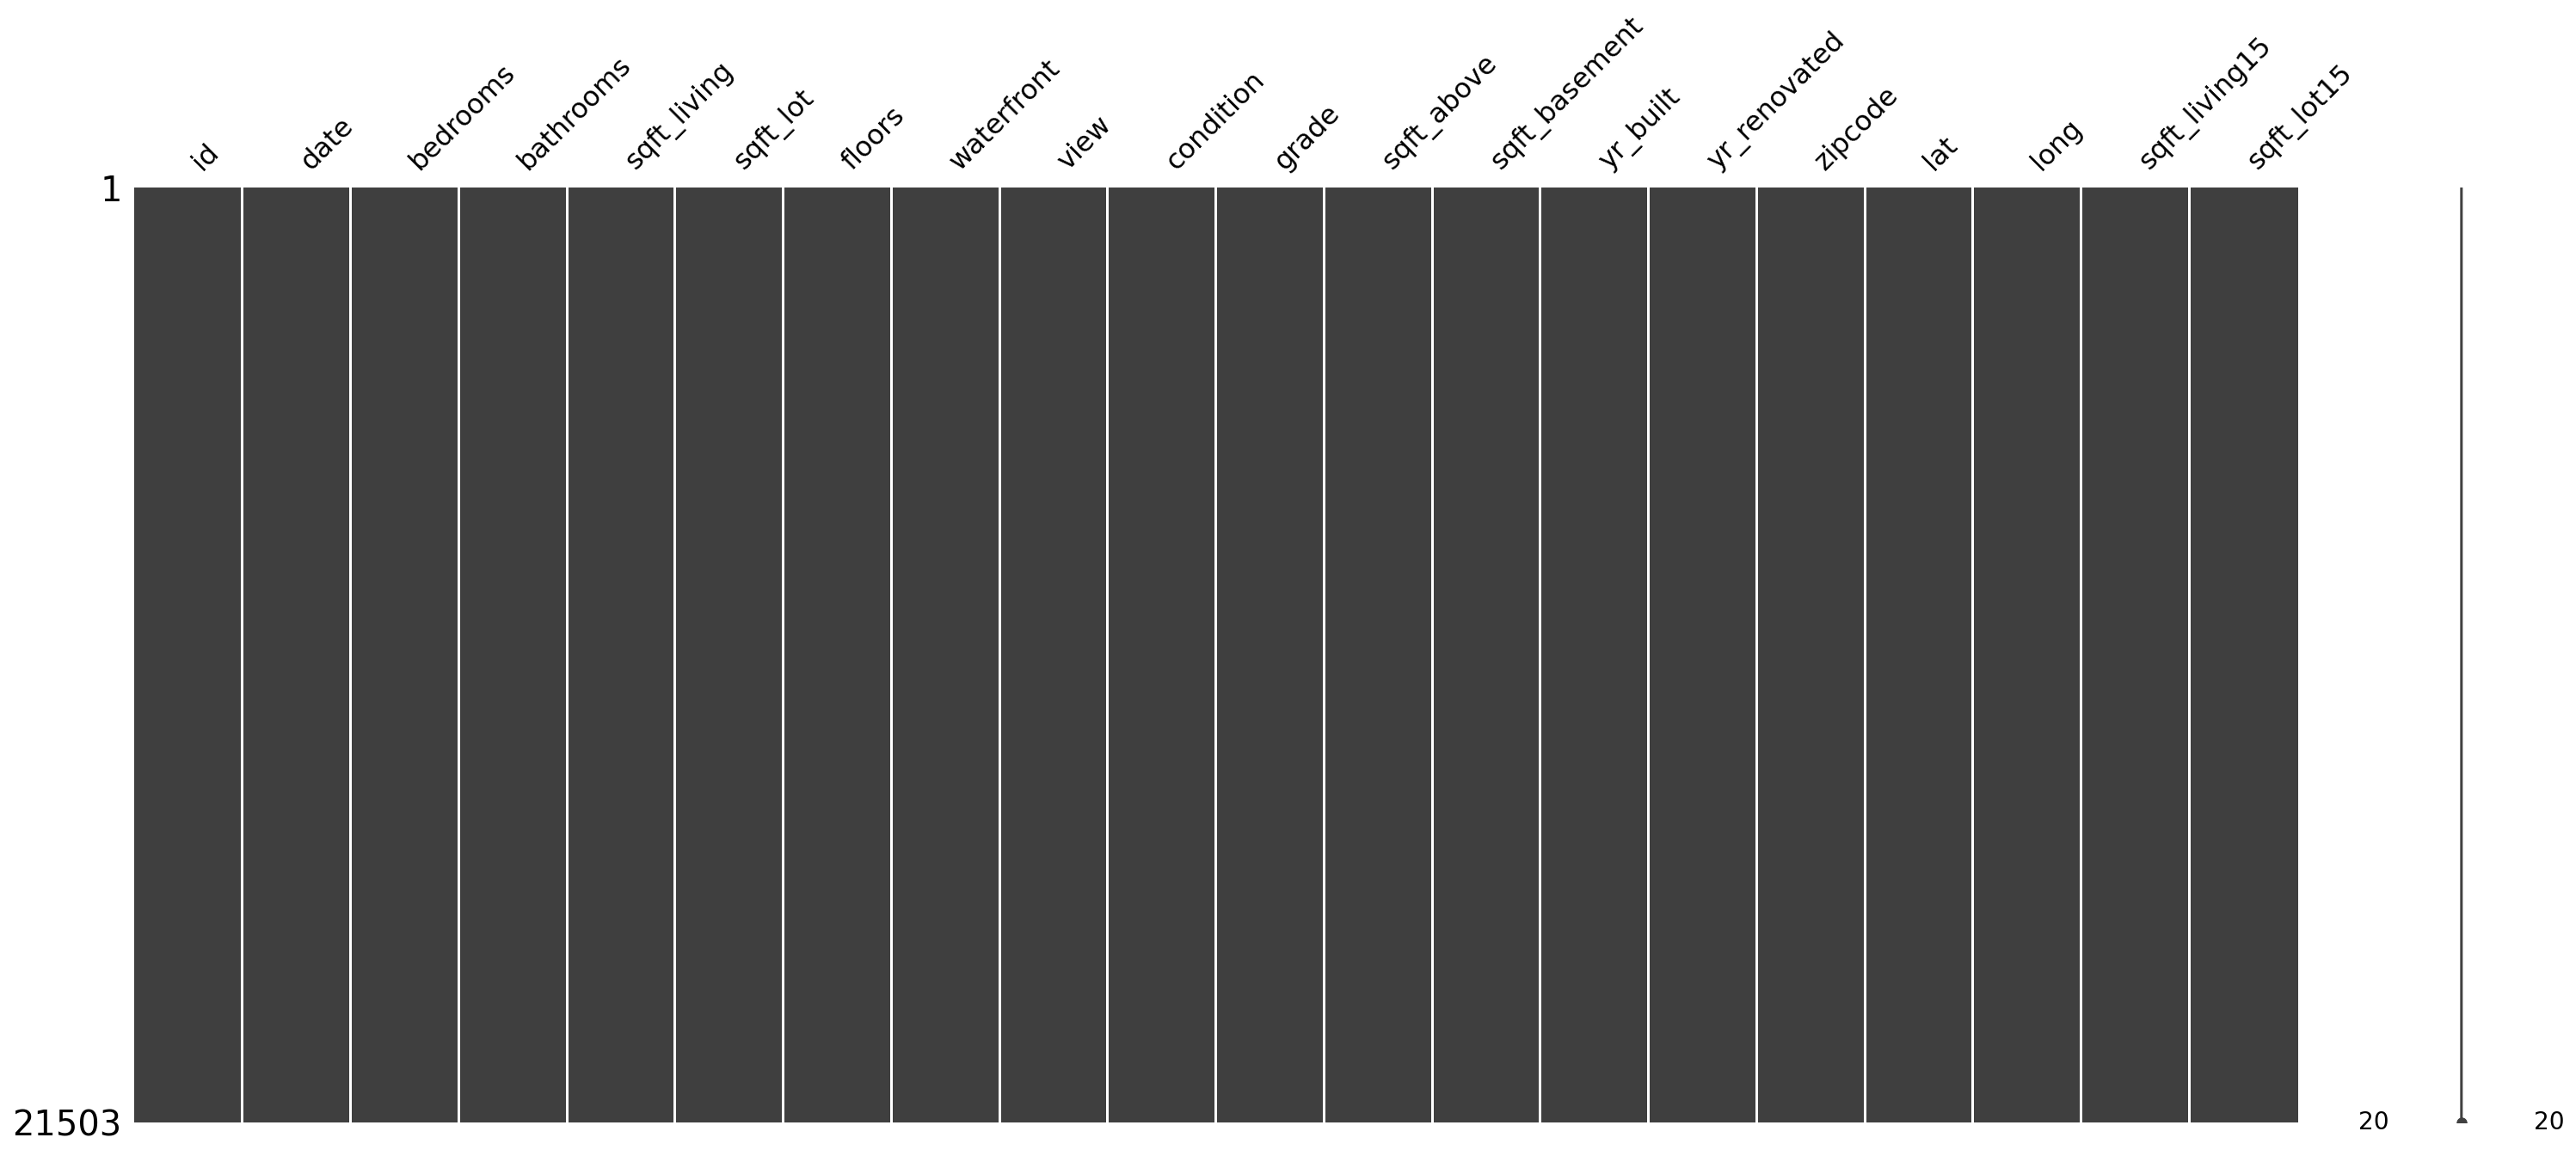

In [8]:
msno.matrix(data)

# 데이터프레임 인덱싱을 이용하여 결측치를 확인한다.


In [9]:
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [10]:
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [11]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


# 학습에  필요하지 않은 id 컬럼삭제


In [12]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


# 오브젝트 타입인 date 컬럼에서 불필요한 데이터를 제거하고 연/월 데이터만을 사용하기 위해 슬라이싱 및 문자열로 변환.


In [13]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 인덱스 변환 
전체 데이터 확인을 위해 테스트 데이터와 학습데이터를 합쳐 놓았기 때문에 마지막 인덱스 값이 데이터의 총 길이가 아닌 테스트데이터의 마지막 인덱스로 표시되어 있어 보기 쉽도록 리셋함.

In [14]:
data.reset_index()

,index,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21501,6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


# 변수들의 분포 확인하기
데이터가 너무 한 쪽에 치우친 분포를 보인다면 다듬는 작업을 해야하기 때문에 데이터를 kdeplot으로 확인합니다.


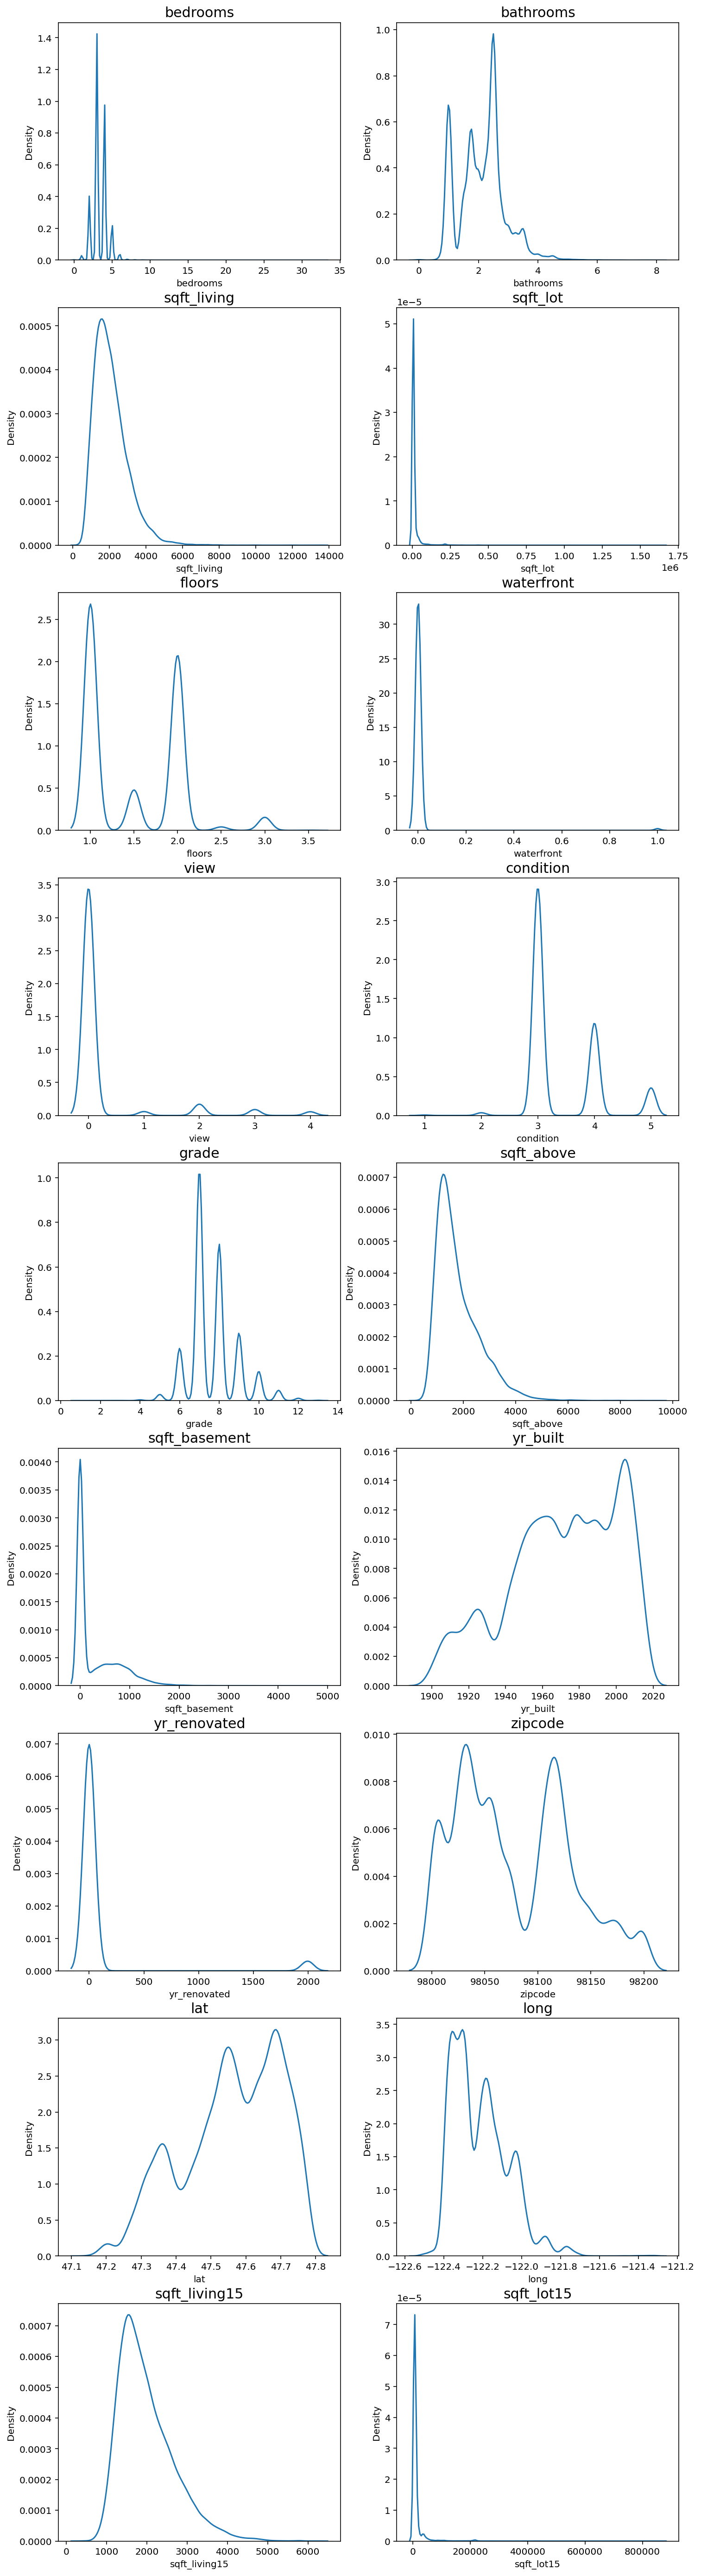

In [15]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

# 그래프 분석 결과
bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15,water front가 한쪽으로  

아래와 같이 치우친 컬럼들을 skew_columns 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환을 해주도록 하겠습니다. numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수입니다.

In [16]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

# 변환 후 분포 재확인


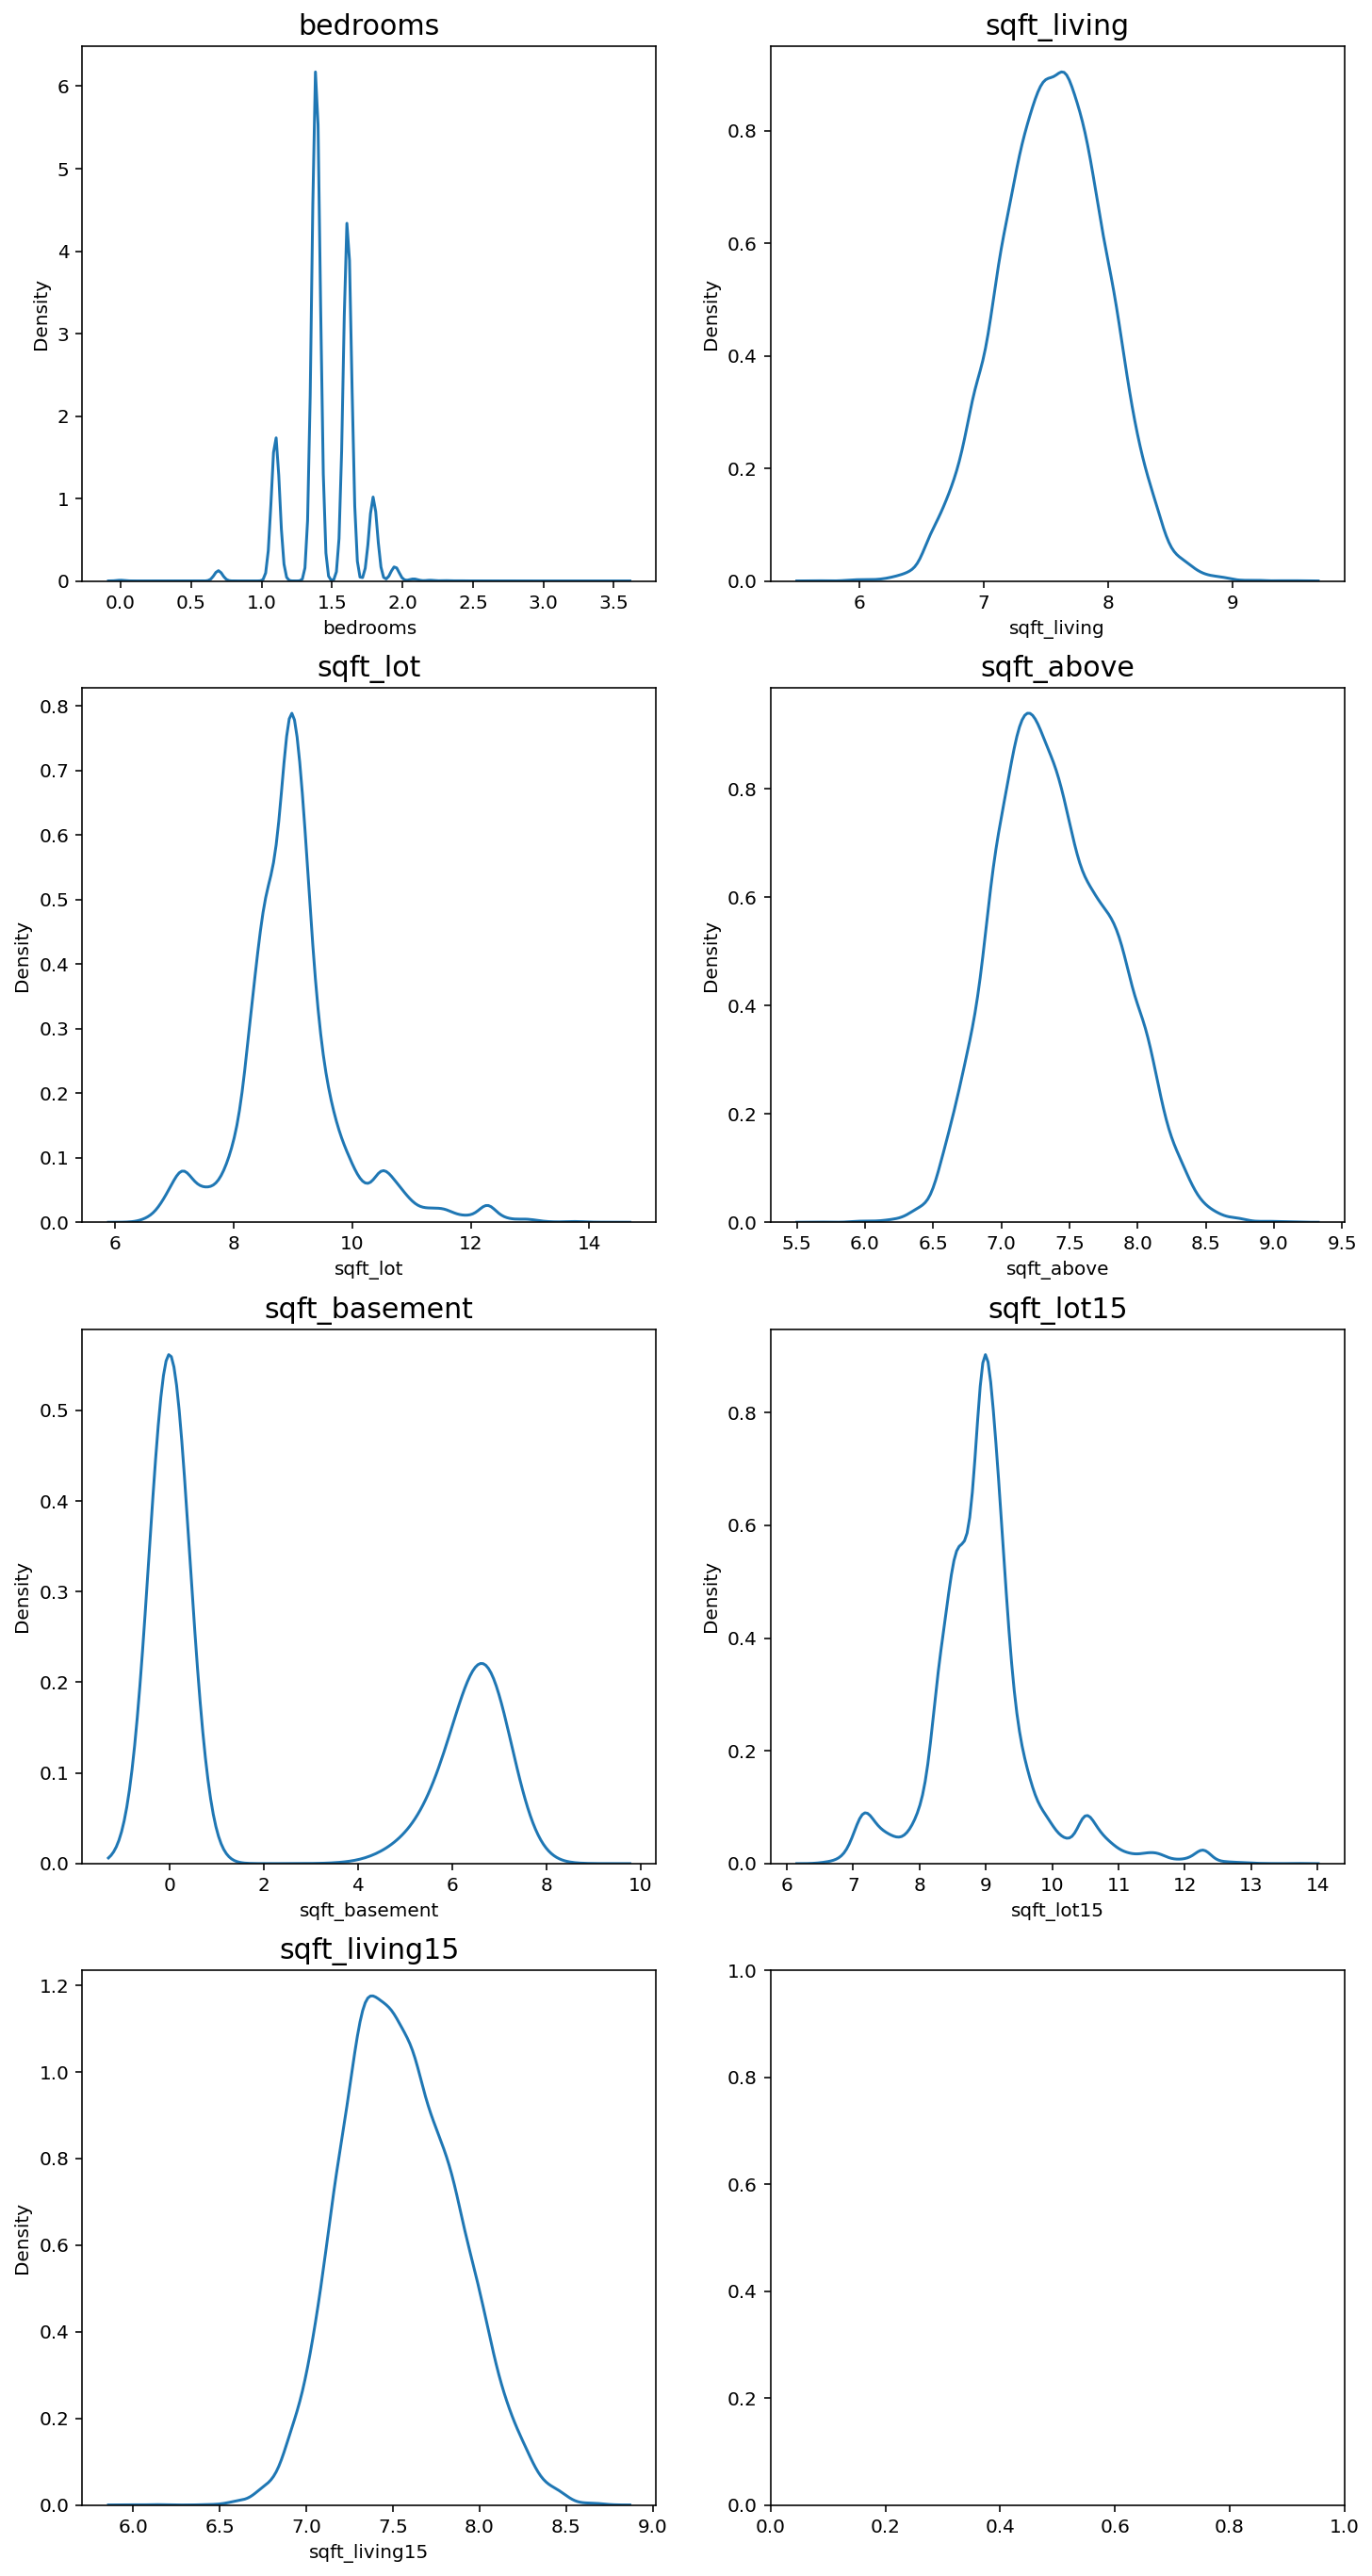

In [17]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

# 원래 price 컬럼의 분포

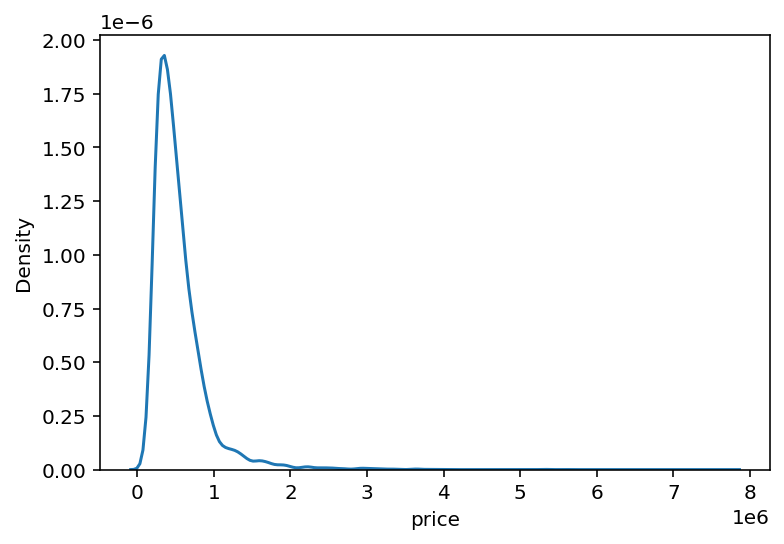

In [18]:
sns.kdeplot(y)
plt.show()

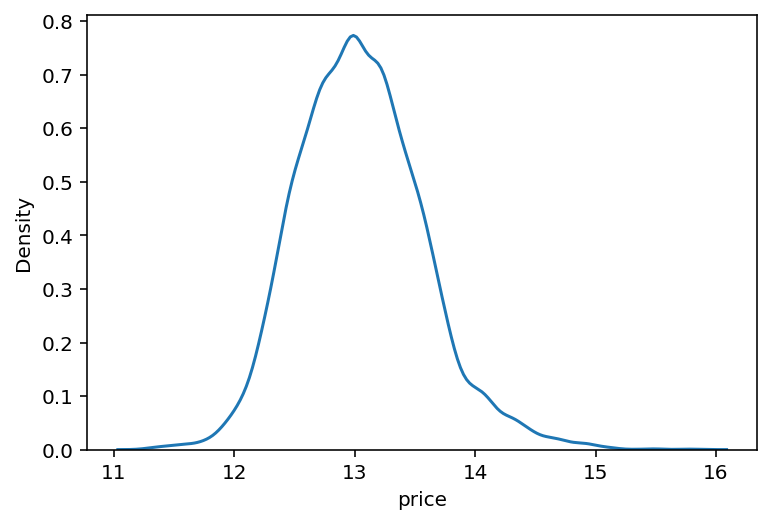

In [19]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

:train_len까지는 학습 데이터, 즉 x에 저장하고, train_len: 는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장

In [20]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


# Average Blending

In [21]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

# Cross Validation 
교차검증으로 모델 간단히 평가

In [22]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [23]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
[06:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:31:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:31:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:31:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819


In [24]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [25]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[06:31:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([ 562566.39221578,  389660.68147617, 1340643.45409443, ...,
        438058.69137012,  345498.01852609,  414241.23776683])

In [26]:
data_dir = '/content/drive/MyDrive/kaggle-kakr-housing-data/data/'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv('/content/drive/MyDrive/kaggle-kakr-housing-data/data/sample_submission.csv')
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [27]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.625664e+05
1,15036,3.896607e+05
2,15037,1.340643e+06
3,15038,3.317573e+05
4,15039,2.966855e+05


In [28]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/drive/MyDrive/kaggle-kakr-housing-data/data/submission.csv


# 다시시작!

In [29]:
data_dir = '/content/drive/MyDrive/kaggle-kakr-housing-data/data'

train_data_path = join(data_dir, '/content/drive/MyDrive/kaggle-kakr-housing-data/data/train.csv')
test_data_path = join(data_dir, '/content/drive/MyDrive/kaggle-kakr-housing-data/data/test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [30]:
train.head() # 데이터 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# date 컬럼 전처리

In [31]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [32]:
y = train['price']
del train['price']

print(train.columns) # 학습데이터에서 라벨 값으로 쓰일 price 컬럼삭제

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [33]:
del train['id']
print(train.columns) # id 컬럼 삭제

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


price 컬럼 말고 테스트데이터에도 동일하게 전처리

In [34]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [35]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

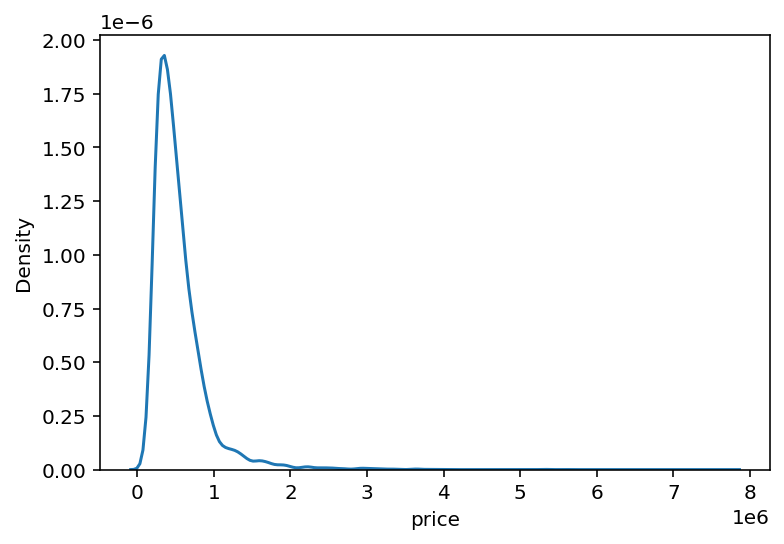

In [36]:
sns.kdeplot(y)
plt.show()

In [37]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [38]:
train.info()# 전체 데이터의 자료형 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [40]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [41]:
random_state=20 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [42]:
lightgbm.__class__.__name__

'LGBMRegressor'

# RMSE값 확인

In [43]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

[06:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 167139.35347826884,
 'LGBMRegressor': 144739.23405373783,
 'RandomForestRegressor': 146772.15191182063,
 'XGBRegressor': 167197.1257819992}

# 그리드서치

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
param_grid = {
    'n_estimators': [1000,3000],
    'max_depth': [15, 20, 25],
    'learning_rate':[0.01, 0.05, 0.1, 0.2],
}

In [46]:
model = LGBMRegressor(random_state=random_state)

In [47]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [15, 20, 25],
                         'n_estimators': [1000, 3000]},
             scoring='neg_mean_squared_error', verbose=1)

# 실험결과 저장 및 확인


In [48]:
grid_model.cv_results_

{'mean_fit_time': array([ 6.2980001 , 15.83287935,  6.26637301, 14.97494855,  6.33096271,
        15.19505792,  4.67230506, 12.86457868,  4.50422149, 12.97470908,
         4.68421297, 12.60358176,  4.48932805, 12.31757693,  4.31175756,
        12.33981123,  4.37323751, 12.34136963,  4.12526956, 11.85982957,
         4.25787926, 12.05332026,  4.08171501, 12.2357244 ]),
 'mean_score_time': array([0.45045066, 1.39088402, 0.43370152, 1.3718966 , 0.45419497,
        1.44646792, 0.40679255, 1.16272755, 0.40013976, 1.18921494,
        0.39421067, 1.26158762, 0.44188709, 1.23731604, 0.41842427,
        1.18946548, 0.37419596, 1.21143212, 0.43979406, 1.24540529,
        0.41310215, 1.20082588, 0.37439241, 0.98430557]),
 'mean_test_score': array([-0.02668558, -0.02574607, -0.02669015, -0.02572525, -0.02669015,
        -0.02571665, -0.02598278, -0.02675436, -0.02604376, -0.02682169,
        -0.02604733, -0.02680916, -0.0269583 , -0.02774527, -0.02678551,
        -0.02749962, -0.02676658, -0.02754

In [49]:
params = grid_model.cv_results_['params']
params

[{'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 1000},
 {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 3000},
 {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 1000},
 {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 3000},
 {'learning_rate': 0.01, 'max_depth': 25, 'n_estimators': 1000},
 {'learning_rate': 0.01, 'max_depth': 25, 'n_estimators': 3000},
 {'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 1000},
 {'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 3000},
 {'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 1000},
 {'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 3000},
 {'learning_rate': 0.05, 'max_depth': 25, 'n_estimators': 1000},
 {'learning_rate': 0.05, 'max_depth': 25, 'n_estimators': 3000},
 {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 1000},
 {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 3000},
 {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 1000},
 {'learning_rate': 0.1, 'max

In [50]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02668558, -0.02574607, -0.02669015, -0.02572525, -0.02669015,
       -0.02571665, -0.02598278, -0.02675436, -0.02604376, -0.02682169,
       -0.02604733, -0.02680916, -0.0269583 , -0.02774527, -0.02678551,
       -0.02749962, -0.02676658, -0.02754256, -0.02877634, -0.02915684,
       -0.02876618, -0.0291552 , -0.02878919, -0.02920056])

In [51]:
results = pd.DataFrame(params)
results['score'] = score

results

,learning_rate,max_depth,n_estimators,score
0,0.01,15,1000,-0.026686
1,0.01,15,3000,-0.025746
2,0.01,20,1000,-0.026690
3,0.01,20,3000,-0.025725
4,0.01,25,1000,-0.026690
5,0.01,25,3000,-0.025717
6,0.05,15,1000,-0.025983
7,0.05,15,3000,-0.026754
8,0.05,20,1000,-0.026044
9,0.05,20,3000,-0.026822


In [52]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])# 음수로 된 MSE값에 -1을 곱해주고 np.sqrt로 루트연산
    results = results.sort_values('RMSLE')

    return results

In [53]:
param_grid = {
    'n_estimators': [1000,3000],
    'max_depth': [10, 15, 20],
    'learning_rate':[0.01, 0.05, 0.1],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
5,0.01,20,3000,-0.025725,0.160391
3,0.01,15,3000,-0.025746,0.160456
1,0.01,10,3000,-0.025752,0.160474
6,0.05,10,1000,-0.025930,0.161028
8,0.05,15,1000,-0.025983,0.161192
10,0.05,20,1000,-0.026044,0.161381
2,0.01,15,1000,-0.026686,0.163357
0,0.01,10,1000,-0.026687,0.163363
4,0.01,20,1000,-0.026690,0.163371
12,0.10,10,1000,-0.026739,0.163521


In [54]:
model = LGBMRegressor(max_depth=15, n_estimators=1000, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.1621595 , 13.09954431, 14.02091313, ..., 13.08603315,
       12.70428379, 13.0125034 ])

In [55]:
prediction = np.expm1(prediction)
prediction

array([ 520298.29888851,  488718.65888407, 1228018.32853393, ...,
        482159.89824268,  329153.91605143,  447978.79127158])

In [56]:
data_dir = '/content/drive/MyDrive/kaggle-kakr-housing-data/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [57]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.202983e+05
1,15036,4.887187e+05
2,15037,1.228018e+06
3,15038,2.922032e+05
4,15039,3.235025e+05


In [59]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '10')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/drive/MyDrive/kaggle-kakr-housing-data/data/submission_lgbm_RMSLE_10.csv


# 결론

1. 이번 프로젝트는 이전 캐글 경진대회에 쓰였던 데이터셋인 집값 예측데이터를 데이터 프레임으로 확인하고 





2. 불필요한 컬럼을 삭제히고, kdeplot을 이용하여 요소가 있다 없다의(0,1) 개념을 제외한 나머지 값들의
그래프를 분석하고 한 쪽으로 치우친 요소 값들을 로그변환 하여 정규분포의 모양에 가깝게 변환해주었습니다 





3. AverageBlending을 이용하여 세가지 모델 예측 값의 평균을 교차검증하여 스코어를 출력해보기도 했습니다.





4. 모델별로 RMSE를 이용하여 손실함수 값을 출력해 비교해보았습니다.





5. 마지막으로 그리드 서치를 이용해 하이퍼파라미터를 추가 및 삭제해보거나 값을 조절하여 캐글 프라이빗 스코어 110000이하를 달성해보는 포로젝트를 진행해 보았습니다.





# 회고

---



## - 이번 프로젝트에서 어려웠던 점

이번 프로젝트에서 어려웠던 점은 그리드서치를 하면서 여러 learning_rate,	max_depth,	n_estimators 하이퍼 파라미터들을 추가해보고 하면서 나온 여러 하이퍼파라미터의 조합의 스코어나 슨실함수를 보고 점점 찾아가는 과정이 힘들었습니다.


---


## - 프로젝트를 진행하면서 알게된 점

무조건적으로 AverageBlending을 하여 모델을 학습시키는 방법보다 시간이 조금 널널하다면 직접 모델을 각각 하나씩 넣어보고 이번 캐글 데이터에 적합한 모델을 찾아보는 것도 좋을 것 같고 그에 따른 하이퍼 파라미터 값을 찾아보는 것도 좋을 것 같다고 생각했습니다.

n_estimators 값이 무조건 높다고 좋은 것이 아니라 오버피팅이 생길 수 있어서 적절한 범위 값을 지정해주는 것이 좋다는 것을 알았습니다.

learning_rate,	max_depth,	n_estimators 등의 하이퍼파라미터를 추가하고 값을 조절하여 모델을 점차적으로 개선시킬 수 있다는 점을 알았습니다.

---


## - 루브릭 평가지표를 맞추기 위해 시도한 것들

- 프라이빗 스코어 기준 달성을 위해 LMS상에서 학습에 필요가 없어 삭제한 ['id']컬럼 말고도 직접데이터 프레임을 보고 ['zipcode']도 필요없을 컬럼이라 생각하고 삭제하였었지만 눈에 띄는 큰차이는 없었습니다.

- 프라이빗 스코어 기준 달성을 위해 n_jobs의 갯수를 5에서 7로 늘려보았지만 이 또한 큰차이는 없었습니다.

- 프라이빗 스코어 기준 달성을 위해 모델을 직접 하나씩 따로 어떤 모델이 이 데이터셋에서 효과적인지 따로 돌려보았습니다.

- 프라이빗 스코어 기준 달성을 위해 이틀 간 최적의 하이퍼 파라미터 조합의 범위를 조절해보고 그에 따른 결과 스코어 점수가 높은것과 손실함수가 가장 낮았던 것을 찾아 반복적으로 110000점 이하를 달성할 때 까지 찾아보았습니다.


---


## - 자기다짐

지금보다 더 어려운 프로젝트들이 많을텐데 조금 더 끈기있게 해보는 습관을 가져야할 것 같습니다.

다양하게 데이터분석을하는 연습하는 시간을 가져야 할 것 같습니다.




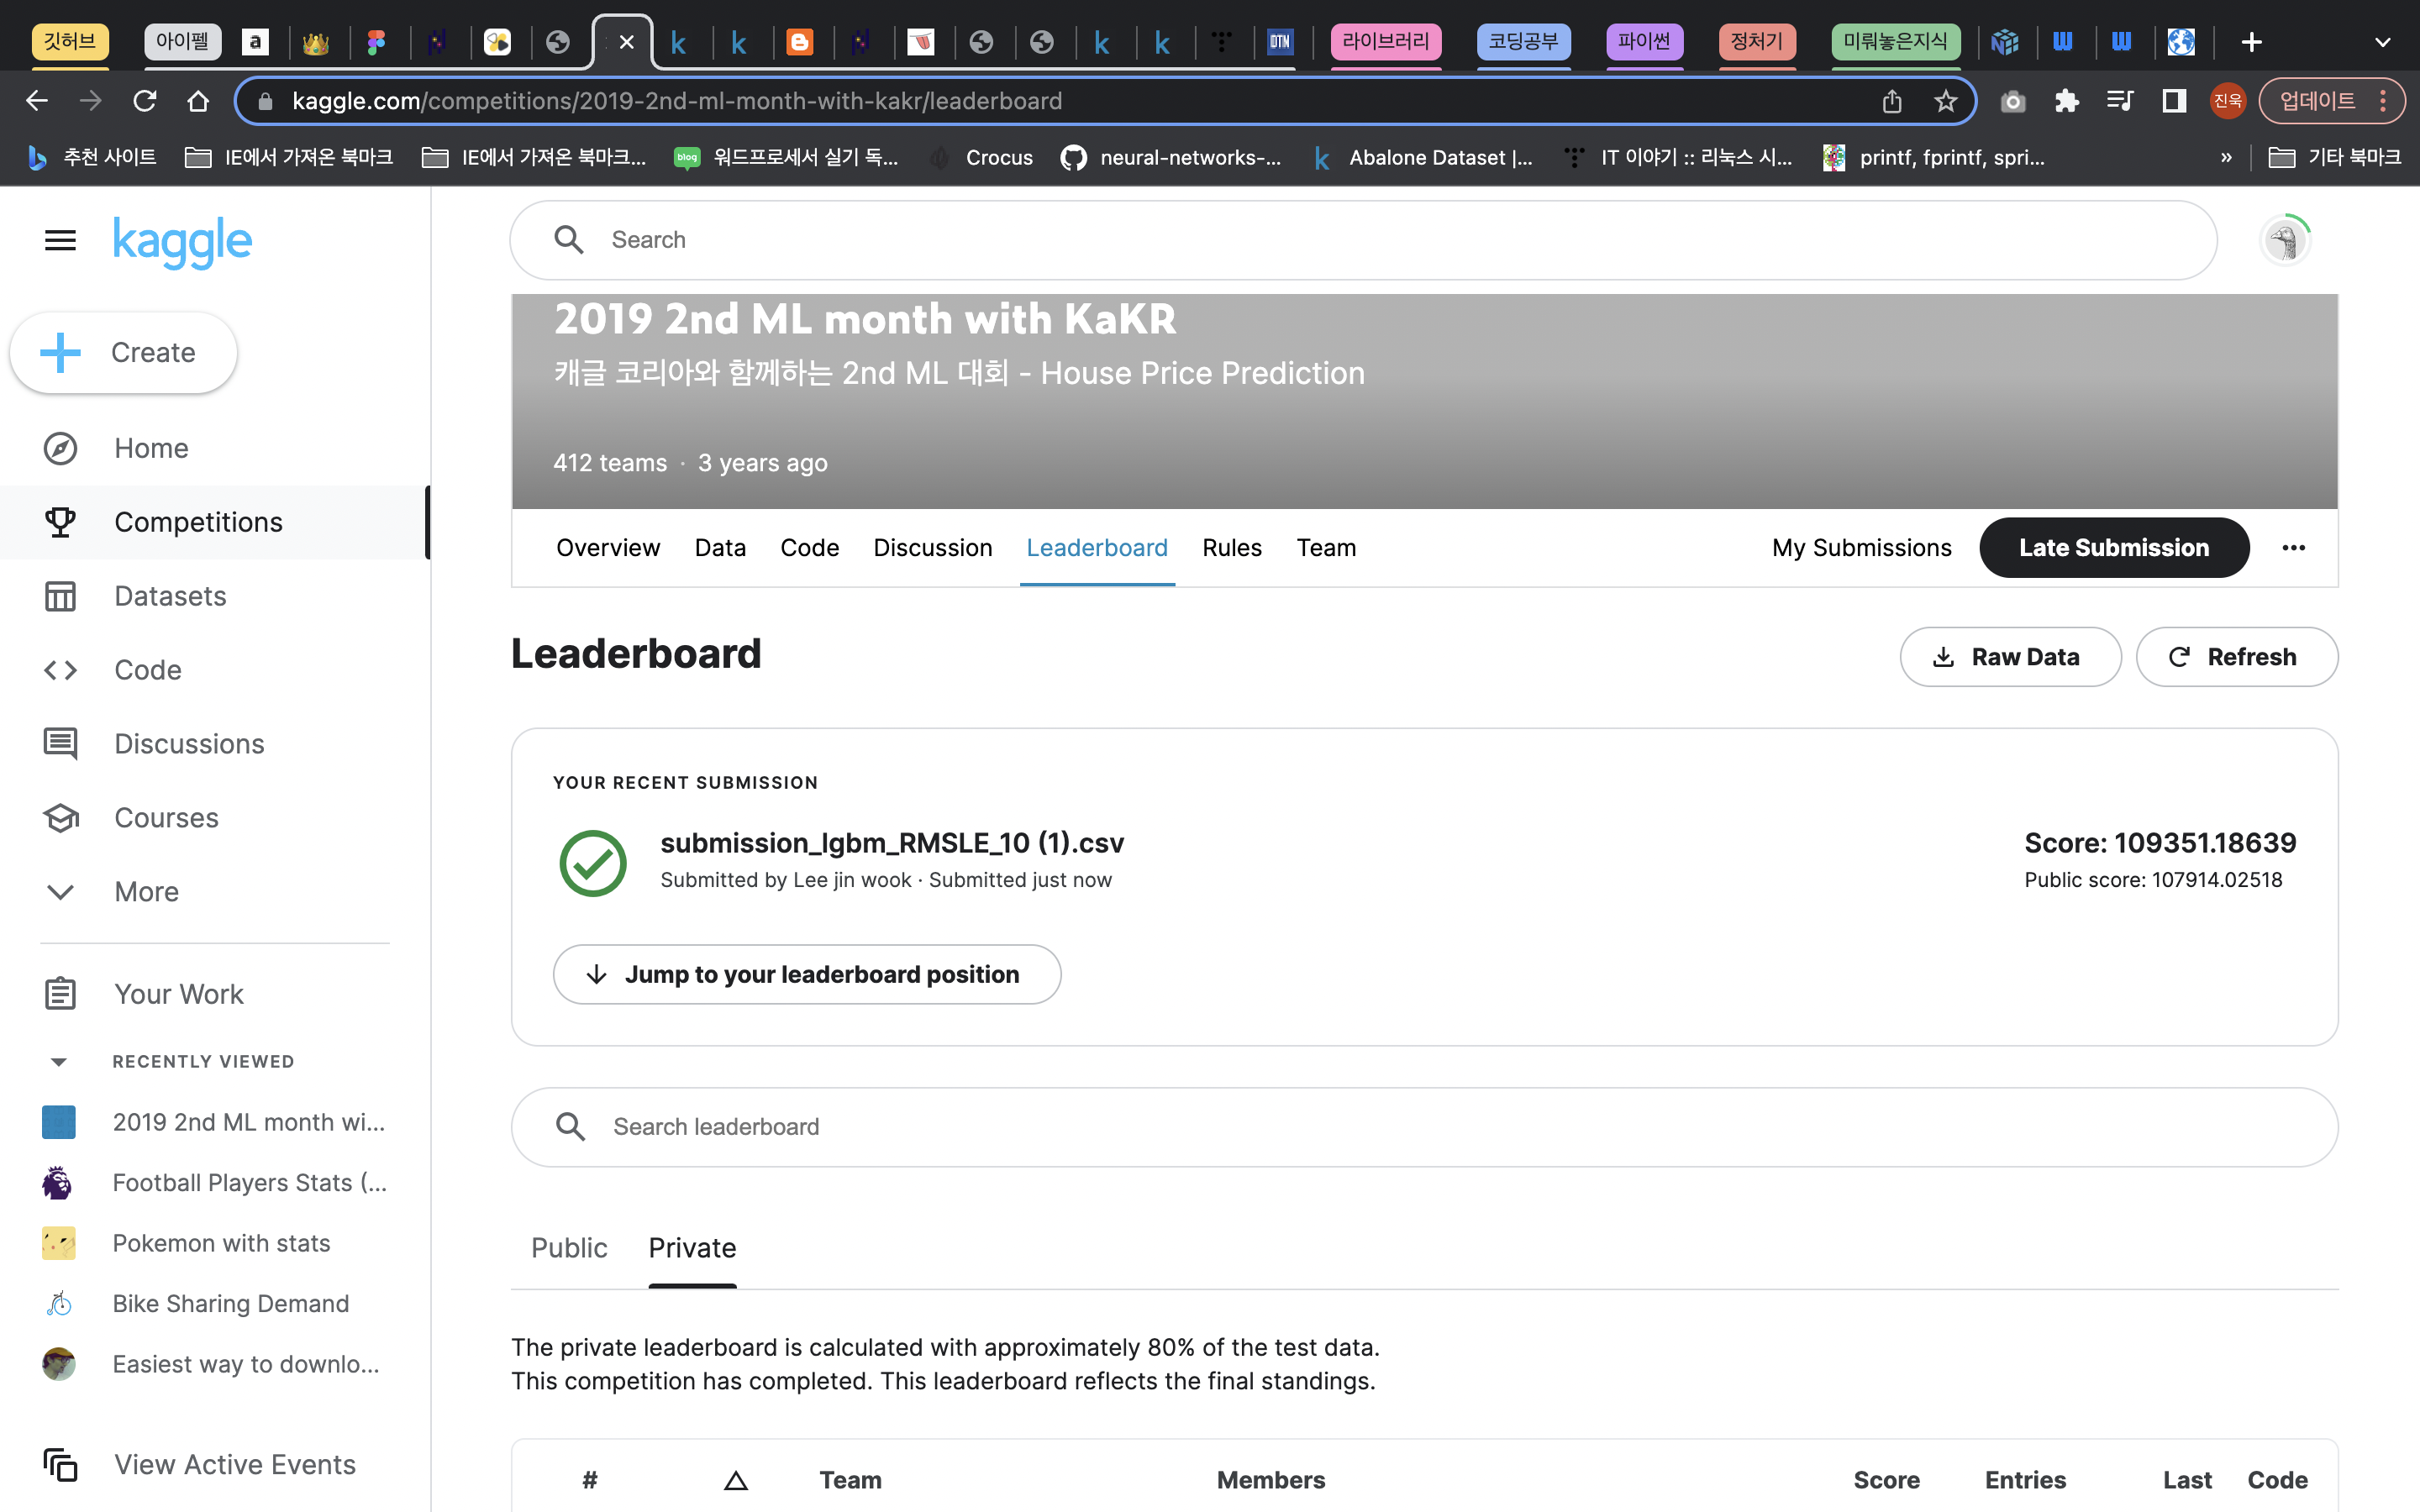